In [1]:
import pandas as pd
import numpy as np
import os
import sys
from trimesh import load_mesh
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from utils.ccf_utils import ccf_pts_convert_to_mm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [2]:
data_dir = '~/capsule/scratch/combined/merfish/spatial_with_pseudocluster.csv'
merfish_ccf = pd.read_csv(data_dir)

In [3]:
ccf_merfish = merfish_ccf[['AP', 'DV', 'ML']].values
ccf_merfish = ccf_merfish/25
ccf_merfish_mm = ccf_pts_convert_to_mm(ccf_merfish)
# ccf_merfish_mm = ccf_merfish/1000
bregma = np.array([216, 18, 228])

In [4]:
ml, ap, dv = 0, 2, 1
ml_mesh, ap_mesh, dv_mesh = 2, 0, 1
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
planes_mesh = {'sag': [ap_mesh, dv_mesh], 'hor': [ml_mesh, ap_mesh], 'cor': [ml_mesh, dv_mesh]}

In [5]:
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)
ccf_center = np.mean(mesh_vertices_mm, axis=0)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.api as sm

# linear regression using ccf as predictor and psuedocluster as response
filter_LC = ccf_merfish_mm[:, dv_mesh] < 4.7
X = sm.add_constant(ccf_merfish_mm[filter_LC])
model = sm.OLS(merfish_ccf[filter_LC]['pseudocluster'], X)
result = model.fit()

primary_axis_vector_LR = result.params[1:] * np.sign(result.params[2])  # First linear discriminant

# Display the primary axis of variation
primary_axis_vector_LR = primary_axis_vector_LR / np.linalg.norm(primary_axis_vector_LR)
print("Primary axis of variation (in MLR space):", primary_axis_vector_LR)
result.summary()

Primary axis of variation (in MLR space): x1    0.671836
x2    0.674737
x3   -0.305558
dtype: float64


/tmp/ipykernel_15503/2918864542.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_axis_vector_LR = result.params[1:] * np.sign(result.params[2])  # First linear discriminant


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pseudocluster   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     404.4
Date:                Thu, 29 May 2025   Prob (F-statistic):          2.31e-209
Time:                        19:22:06   Log-Likelihood:                 1921.6
No. Observations:                2213   AIC:                            -3835.
Df Residuals:                    2209   BIC:                            -3812.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3709      0.077      4.790      0.000       0.219       0.523
x1            -0.1841      0.014    -13.332      0.000      -0.211      -0.157
x2            -0.1849      0.008    -21.949      0.000      -0.201      -0.168
x3             0.0837      0.015      5.488      0.000       0.054       0.114
==============================================================================
Omnibus:                      149.833   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              259.656
Skew:                           0.503   Prob(JB):                     4.13e-57
Kurtosis:                       4.343   Cond. No.                         239.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/tmp/ipykernel_15503/2462738265.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_LR[planes_mesh[plane][0]], -primary_axis_vector_LR[planes_mesh[plane][1]],scale=3, color='red', label='Merfish')
/tmp/ipykernel_15503/2462738265.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_LR[planes_mesh[plane][0]], primary_axis_vector_LR[planes_mesh[plane][1]],scale=3, color='red', label='Merfish')


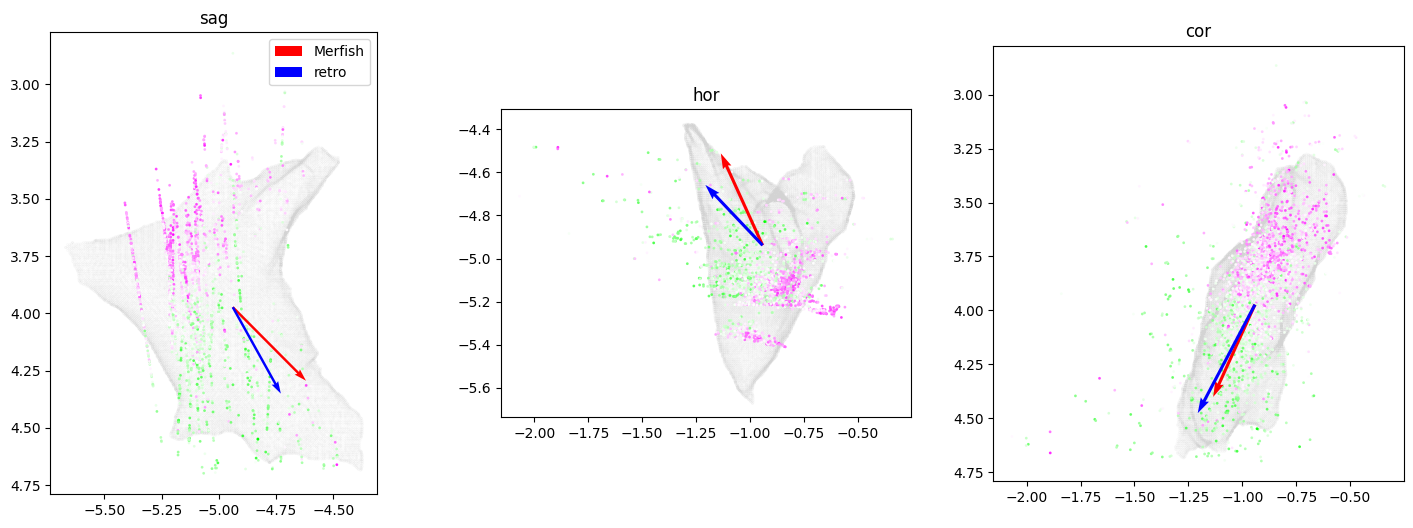

In [13]:
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3)
from matplotlib.cm import plasma
from matplotlib.colors import to_hex
proj_vector = np.array([0.44137469,  0.79373018, -0.41854604])
category_order = ['CTX', 'CB', 'SP']
category_to_index = {cat: i for i, cat in enumerate(category_order)}

# Normalize indices to [0, 1] for colormap
norm_indices = [category_to_index[cat] / (len(category_order) - 1) for cat in category_order]
colors = [plasma(val) for val in norm_indices]
green_white_magenta = LinearSegmentedColormap.from_list(
    "green_white_magenta",
    ["#00FF00", "#FFFFFF", "#FF00FF"]
)
for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.7, s = 0.002)
    ax.scatter(ccf_merfish_mm[filter_LC, planes_mesh[plane][0]], ccf_merfish_mm[filter_LC, planes_mesh[plane][1]], c = merfish_ccf[filter_LC]['pseudocluster'], cmap=green_white_magenta, alpha=0.9, s = 1)
    if planes[plane][1] == dv:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_LR[planes_mesh[plane][0]], -primary_axis_vector_LR[planes_mesh[plane][1]],scale=3, color='red', label='Merfish')
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], proj_vector[planes_mesh[plane][0]], -proj_vector[planes_mesh[plane][1]],scale=3, color='b', label='retro')
    else:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_LR[planes_mesh[plane][0]], primary_axis_vector_LR[planes_mesh[plane][1]],scale=3, color='red', label='Merfish')
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], proj_vector[planes_mesh[plane][0]], proj_vector[planes_mesh[plane][1]],scale=3, color='b', label='retro')
    ax.set_title(plane)
    if plane == 'sag':
        ax.legend()
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    ax.set_aspect(aspect='equal')


In [276]:
sds = [np.percentile(ccf_neurons_mm[(retro_ccf['injection_region'] == tar) & (ccf_neurons_mm_center_mask)], [10, 30, 50, 70, 90], axis=0) for tar in category_order]


In [285]:
ind_per, bin_count-1-ind_per

(3, 4)

In [284]:
pers

array([ 5.        , 17.85714286, 30.71428571, 43.57142857, 56.42857143,
       69.28571429, 82.14285714, 95.        ])